### IMPORTS

In [243]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### SETTING THE DATASET PATH

In [244]:
## TYPES OF PRE-PROCESSED DS AVAILABLE:
D1_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D1/"
D1_LINEAR_GAUSIAN_300px = "D://300px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D2/"
D2_LINEAR_GAUSIAN_300px = "D://300px_LI_GB_D2/"
D2_CUBIC_GAUSIAN_250px = "D://250px_CI_GB_D2/"
D1_D2_MIXED_250px = "D://D1_D2_MIXED_250px/"
## ^ DATASET.NO_INTERPOLATION_BLUR-FILTER_IMG-SIZE ^

#SELECTING DATASET

ds_type = D1_LINEAR_GAUSIAN_250px

#SETTING THE PATH
dataset_path = signature_types = os.listdir(ds_type)
print(signature_types)

['fogeries', 'original']


In [245]:
print("Types of signatures: ", len(dataset_path))

Types of signatures:  2


In [246]:
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
print(signs)

[('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_1.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_10.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_11.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_12.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_13.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_14.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_15.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_16.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_17.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_18.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_19.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_2.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_20.png.png'), ('fogeries', 'D://250px_LI_GB_D1//fogeries/forgeries_10_21.png.png'), ('fogeries', 'D://250

In [247]:
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
print(signs_df.head())

  sign type                                              image
0  fogeries  D://250px_LI_GB_D1//fogeries/forgeries_10_1.pn...
1  fogeries  D://250px_LI_GB_D1//fogeries/forgeries_10_10.p...
2  fogeries  D://250px_LI_GB_D1//fogeries/forgeries_10_11.p...
3  fogeries  D://250px_LI_GB_D1//fogeries/forgeries_10_12.p...
4  fogeries  D://250px_LI_GB_D1//fogeries/forgeries_10_13.p...


In [248]:
print("Total number of signs in the dataset: ", len(signs_df))

Total number of signs in the dataset:  2640


In [249]:
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
fogeries    1320
original    1320
Name: sign type, dtype: int64


### CREATING LIST ARRAY OF IMAGES WITH LABELS

In [250]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing original: 100%|██████████| 1320/1320 [00:05<00:00, 262.20it/s]


In [251]:
print(labels)

['fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fogeries', 'fo

In [252]:
images = np.array(images)
images.shape

(2640, 250, 250, 3)

In [253]:
images = images.astype('float32') / 255.0

In [254]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
print(Y.shape)

(2640, 2)


### SPLITTING THE DATASET (80 : 20)

In [255]:
images, Y = shuffle(images,Y,random_state=1)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.2, random_state=1)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2112, 250, 250, 3)
(528, 250, 250, 3)
(2112, 2)
(528, 2)


In [256]:
train_x = train_x / 255.0
test_x = test_x / 255.0

### PROPOSED CNN MODEL (based on ijerph)

In [257]:
cnn = models.Sequential([
     layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu', input_shape=(250, 250, 3)),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.BatchNormalization(),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.GlobalAveragePooling2D(),
     layers.BatchNormalization(),
     layers.Dense(128, activation= 'sigmoid'),
     layers.BatchNormalization(),
     layers.Flatten(),
     layers.Dropout(0.2),
     layers.Dense(2, activation= 'softmax')
     ])

### PROPOSED CNN MODEL (based on GWO)

In [258]:
# cnn = models.Sequential([
#   layers.Conv2D(filters=55, kernel_size=(3, 3), activation= 'relu', input_shape=(250, 250, 3)),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=130, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=155, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Flatten(),
#   layers.Dense(2, activation = 'softmax')
#   ])

In [259]:
# opti = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
# cnn.compile(optimizer=opti,loss='BinaryCrossentropy',metrics=['accuracy'])
# cnn.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])
cnn.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['accuracy'])
history = cnn.fit(train_x, train_y, validation_data=(test_x,test_y), epochs = 10)

Epoch 1/10
66/66 [==============================] - 51s 750ms/step - loss: 0.0784 - accuracy: 0.9725 - val_loss: 1.1747 - val_accuracy: 0.4830
Epoch 2/10
66/66 [==============================] - 48s 735ms/step - loss: 0.0191 - accuracy: 0.9915 - val_loss: 0.7513 - val_accuracy: 0.4830
Epoch 3/10
66/66 [==============================] - 48s 735ms/step - loss: 0.0306 - accuracy: 0.9915 - val_loss: 0.7435 - val_accuracy: 0.4830
Epoch 4/10
66/66 [==============================] - 48s 734ms/step - loss: 0.0560 - accuracy: 0.9882 - val_loss: 1.0498 - val_accuracy: 0.5170
Epoch 5/10
66/66 [==============================] - 49s 737ms/step - loss: 0.0310 - accuracy: 0.9901 - val_loss: 1.2388 - val_accuracy: 0.5170
Epoch 6/10
66/66 [==============================] - 49s 738ms/step - loss: 0.0119 - accuracy: 0.9972 - val_loss: 2.9421 - val_accuracy: 0.5170
Epoch 7/10
66/66 [==============================] - 48s 735ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.2171 - val_accuracy: 0.5170

### PLOTTING training_acc & testing_acc at each epoch

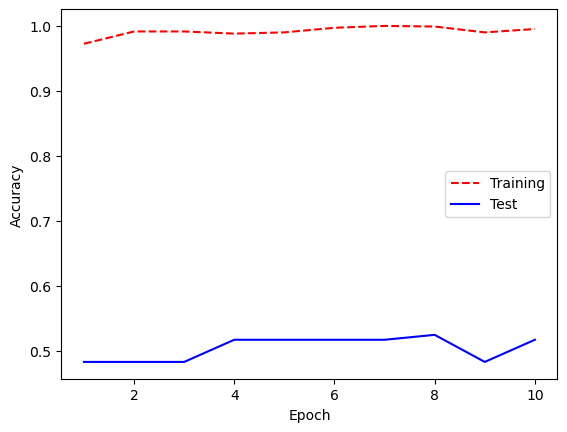

In [260]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(training_acc) + 1)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [261]:
testing = cnn.evaluate(test_x, test_y)
predictions = cnn.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(classification_report(test_y,pred_y))

17/17 [==============================] - 3s 146ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       273
           1       0.00      0.00      0.00       255

    accuracy                           0.52       528
   macro avg       0.26      0.50      0.34       528
weighted avg       0.27      0.52      0.35       528



C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\einzeL\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [262]:
cm = confusion_matrix(test_y, pred_y)
print(cm)

[[273   0]
 [255   0]]


### OBSERVATIONS
| DATASET USED            | Genuine / Forg   | random_state | Split Ratio | EPOCHS | CNN-1 (ijerph) ACC%, LOSS                   | CNN-2 (jksu) ACC%, LOSS|
| ----------------------- |      :----:      | :----------: | :---------: | :----: | :-----------------------------------------: | :-------------------: |
| D1_LINEAR_GAUSIAN_250px | G: 1321, F: 1321 |     42       | 80:20       |   50   | TrA: 99, TeA: 49, TrL: 0.012, TeL: 6.146    | TrA: 50, TeA: 49, TrL: 0.69, TeL: 6.146 |
| D1_LINEAR_GAUSIAN_250px | G: 1321, F: 1321 |     42       | 80:20       |   10   | ----------------------------------------    | TrA: 50, TeA: 49, TrL: 0.69, TeL: 6.146 |
| D2_LINEAR_GAUSIAN_250px | G: 887,  F: 734  |     42       | 80:20       |   50   | TrA: 99, TeA: 92, TrL: 0.015, TeL: 0.476    | --------------------------------------- |
| D2_LINEAR_GAUSIAN_250px | G: 887,  F: 734  |     42       | 80:20       |   10   | ----------------------------------------    | --------------------------------------- |